In [ ]:
!pip install fuzzywuzzy

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 22.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import fuzzywuzzy.process
import optuna
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("dummy_receipts.csv")
df = df.sample(frac=1).reset_index(drop=True)

# Define categories
categories = ["food", "clothing", "transport", "alcohol/entertainment", "home/appliances", "other"]

# Load sentence transformer model
embedder = SentenceTransformer("all-MiniLM-L6-v2")

# Function to clean item names using fuzzy matching
def clean_item_name(item, choices):
    match, score = fuzzywuzzy.process.extractOne(item, choices)
    return match if score > 80 else item  # Use threshold to avoid incorrect replacements

df["cleaned_item"] = df["item"].apply(lambda x: clean_item_name(x, categories))

# Convert item names to embeddings
embeddings = embedder.encode(df["cleaned_item"].tolist(), convert_to_tensor=True)

# Label encode categories
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df["class"].map(lambda x: x if x in categories else "other"))

# Train-test split, including validation split
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define neural network classifier
class ReceiptClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, dropout_rate=0.3):
        super(ReceiptClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn2 = nn.BatchNorm1d(hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, len(categories))
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x


# Define training function with validation performance tracking
def train_model(model, train_data, train_labels, val_data, val_labels, epochs=150, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Lists to store the loss and accuracy for plotting
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        train_outputs = model(train_data)
        train_loss = criterion(train_outputs, train_labels)
        train_loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, train_predicted = torch.max(train_outputs, 1)
        train_correct = (train_predicted == train_labels).sum().item()
        train_accuracy = train_correct / train_labels.size(0)

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(val_data)
            val_loss = criterion(val_outputs, val_labels)

            # Calculate validation accuracy
            _, val_predicted = torch.max(val_outputs, 1)
            val_correct = (val_predicted == val_labels).sum().item()
            val_accuracy = val_correct / val_labels.size(0)

        # Append losses and accuracies to their respective lists
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # Print loss and accuracy every 5 epochs
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}, "
                  f"Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Plot the loss and accuracy curves for both train and validation
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(range(epochs), train_losses, color='tab:red', label='Train Loss')
    ax1.plot(range(epochs), val_losses, color='tab:orange', label='Validation Loss')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy', color='tab:blue')
    ax2.plot(range(epochs), train_accuracies, color='tab:blue', label='Train Accuracy')
    ax2.plot(range(epochs), val_accuracies, color='tab:green', label='Validation Accuracy')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    fig.tight_layout()
    plt.title('Train and Validation Loss and Accuracy over Epochs')
    plt.legend()
    plt.show()


# Convert data to torch tensors
X_train_tensor = torch.tensor(X_train.numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val.numpy(), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.numpy(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Initialize and train model
model = ReceiptClassifier(input_dim=X_train.shape[1])
train_model(model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor)

# Save model
torch.save(model.state_dict(), "receipt_classifier.pth")
print("Model training complete and saved.")


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

Test Accuracy: 0.8545


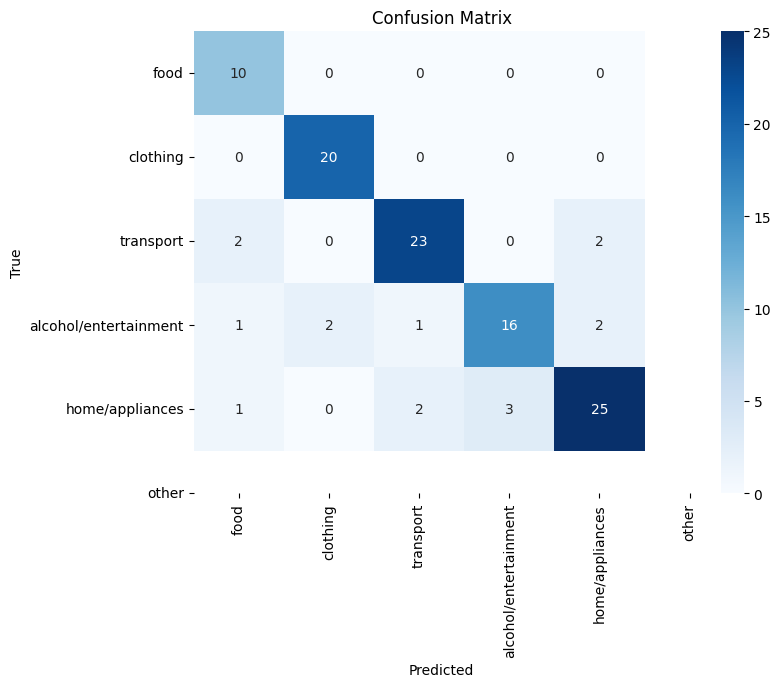

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define evaluation function
def evaluate_model(model, X_test, y_test):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)

    # Convert predictions and true labels to numpy arrays for compatibility with sklearn
    predicted = predicted.numpy()
    y_test = y_test.numpy()

    # Calculate accuracy
    accuracy = accuracy_score(y_test, predicted)
    print(f"Test Accuracy: {accuracy:.4f}")

    # Generate confusion matrix
    cm = confusion_matrix(y_test, predicted)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Convert test data to torch tensors
X_test_tensor = torch.tensor(X_test.numpy(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Evaluate model on test data
evaluate_model(model, X_test_tensor, y_test_tensor)


In [ ]:
print("Train label distribution:", np.bincount(y_train))
print("Validation label distribution:", np.bincount(y_val))
print("Test label distribution:", np.bincount(y_test))


Train label distribution: [ 42  51  91  58 110]
Validation label distribution: [ 8  9 32 10 29]
Test label distribution: [10 20 27 22 31]


Using device: cuda


<ipython-input-11-c794b6fd08e4>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = torch.tensor(embedder.encode(df["cleaned_item"].tolist(), convert_to_tensor=True)).to(device)


Epoch 5/300, Train Loss: 1.7315, Train Accuracy: 0.5284, Val Loss: 1.7260, Val Accuracy: 0.5341
Epoch 10/300, Train Loss: 1.6709, Train Accuracy: 0.5653, Val Loss: 1.6701, Val Accuracy: 0.5227
Epoch 15/300, Train Loss: 1.6019, Train Accuracy: 0.5767, Val Loss: 1.6048, Val Accuracy: 0.5341
Epoch 20/300, Train Loss: 1.5199, Train Accuracy: 0.6051, Val Loss: 1.5334, Val Accuracy: 0.5341
Epoch 25/300, Train Loss: 1.4391, Train Accuracy: 0.5966, Val Loss: 1.4599, Val Accuracy: 0.5341
Epoch 30/300, Train Loss: 1.3512, Train Accuracy: 0.5994, Val Loss: 1.3875, Val Accuracy: 0.5455
Epoch 35/300, Train Loss: 1.2700, Train Accuracy: 0.6108, Val Loss: 1.3164, Val Accuracy: 0.5341
Epoch 40/300, Train Loss: 1.1936, Train Accuracy: 0.6165, Val Loss: 1.2456, Val Accuracy: 0.5568
Epoch 45/300, Train Loss: 1.1067, Train Accuracy: 0.6534, Val Loss: 1.1761, Val Accuracy: 0.6136
Epoch 50/300, Train Loss: 1.0294, Train Accuracy: 0.6847, Val Loss: 1.1101, Val Accuracy: 0.6477
Epoch 55/300, Train Loss: 0.947

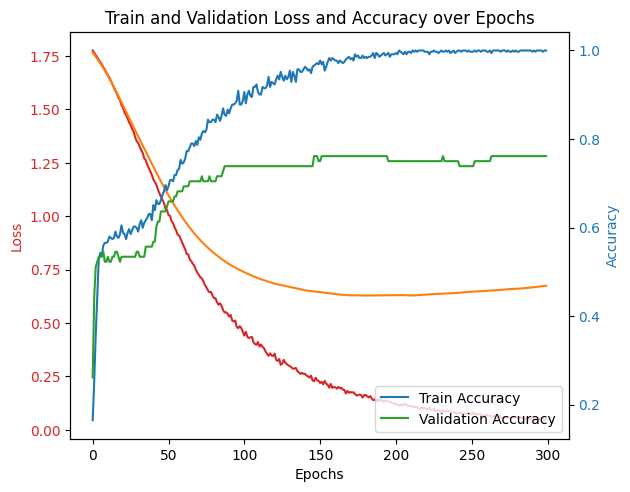

Model training complete and saved.
Test Accuracy: 0.8455


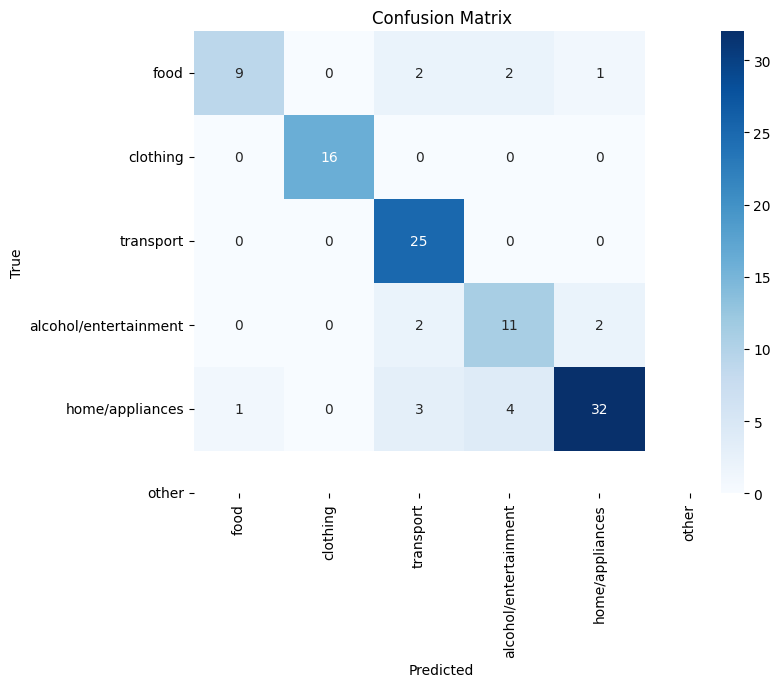

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import fuzzywuzzy.process
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
df = pd.read_csv("dummy_receipts.csv")
df = df.sample(frac=1).reset_index(drop=True)

# Define categories
categories = ["food", "clothing", "transport", "alcohol/entertainment", "home/appliances", "other"]

# Load sentence transformer model
embedder = SentenceTransformer("all-MiniLM-L6-v2").to(device)

# Function to clean item names using fuzzy matching
def clean_item_name(item, choices):
    match, score = fuzzywuzzy.process.extractOne(item, choices)
    return match if score > 80 else item  # Use threshold to avoid incorrect replacements

df["cleaned_item"] = df["item"].apply(lambda x: clean_item_name(x, categories))

# Label encode categories
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df["class"].map(lambda x: x if x in categories else "other"))

# Convert item names to embeddings
embeddings = torch.tensor(embedder.encode(df["cleaned_item"].tolist(), convert_to_tensor=True)).to(device)

# Train-test split, including validation split
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define fine-tuned SentenceTransformer model with classification head
class FineTunedSentenceTransformer(nn.Module):
    def __init__(self, base_model, num_classes, dropout_rate=0.3):
        super(FineTunedSentenceTransformer, self).__init__()
        self.base_model = base_model
        self.classifier = nn.Sequential(
            nn.Linear(base_model.get_sentence_embedding_dimension(), 128),  # Fully connected layer
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)  # Output layer with number of categories
        )

    def forward(self, embeddings):
        logits = self.classifier(embeddings)
        return logits

# Define training function with validation performance tracking
def train_model(model, train_data, train_labels, val_data, val_labels, epochs=150, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Move data to GPU
    train_labels, val_labels = torch.tensor(train_labels).to(device), torch.tensor(val_labels).to(device)

    # Lists to store the loss and accuracy for plotting
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        train_outputs = model(train_data)
        train_loss = criterion(train_outputs, train_labels)
        train_loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, train_predicted = torch.max(train_outputs, 1)
        train_correct = (train_predicted == train_labels).sum().item()
        train_accuracy = train_correct / train_labels.size(0)

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(val_data)
            val_loss = criterion(val_outputs, val_labels)

            # Calculate validation accuracy
            _, val_predicted = torch.max(val_outputs, 1)
            val_correct = (val_predicted == val_labels).sum().item()
            val_accuracy = val_correct / val_labels.size(0)

        # Append losses and accuracies to their respective lists
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # Print loss and accuracy every 5 epochs
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}, "
                  f"Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Plot the loss and accuracy curves for both train and validation
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(range(epochs), train_losses, color='tab:red', label='Train Loss')
    ax1.plot(range(epochs), val_losses, color='tab:orange', label='Validation Loss')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy', color='tab:blue')
    ax2.plot(range(epochs), train_accuracies, color='tab:blue', label='Train Accuracy')
    ax2.plot(range(epochs), val_accuracies, color='tab:green', label='Validation Accuracy')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    fig.tight_layout()
    plt.title('Train and Validation Loss and Accuracy over Epochs')
    plt.legend()
    plt.show()

# Initialize the fine-tuned model
model = FineTunedSentenceTransformer(embedder, num_classes=len(categories)).to(device)

# Train the model
train_model(model, X_train, y_train, X_val, y_val,epochs=300)

# Save model
torch.save(model.state_dict(), "receipt_classifier_finetuned.pth")
print("Model training complete and saved.")

# Define evaluation function
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)

    predicted = predicted.cpu().numpy()
    y_test = torch.tensor(y_test).cpu().numpy()

    accuracy = accuracy_score(y_test, predicted)
    print(f"Test Accuracy: {accuracy:.4f}")

    cm = confusion_matrix(y_test, predicted)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate the model
evaluate_model(model, X_test, y_test)


Using device: cuda


<ipython-input-13-2b10478f63b7>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = torch.tensor(embedder.encode(df["cleaned_item"].tolist(), convert_to_tensor=True)).to(device)


Test Accuracy: 0.0674


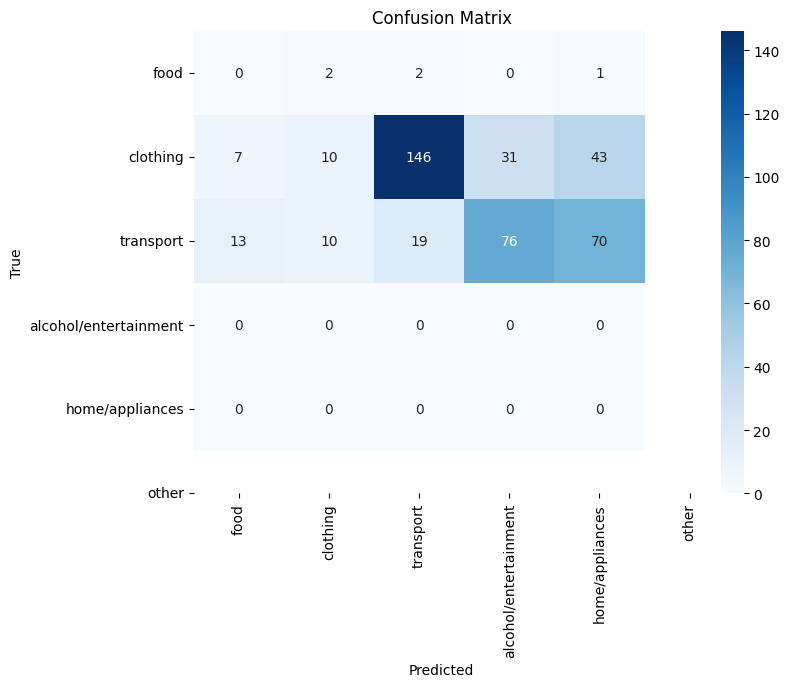

In [ ]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
df = pd.read_csv("receipts_data_final.csv")
df = df.sample(frac=1).reset_index(drop=True)

# Define categories
categories = ["food", "clothing", "transport", "alcohol/entertainment", "home/appliances", "other"]

# Load sentence transformer model
embedder = SentenceTransformer("all-MiniLM-L6-v2").to(device)

# Function to clean item names using fuzzy matching
def clean_item_name(item, choices):
    match, score = fuzzywuzzy.process.extractOne(item, choices)
    return match if score > 80 else item  # Use threshold to avoid incorrect replacements

df["cleaned_item"] = df["item"].apply(lambda x: clean_item_name(x, categories))

# Label encode categories
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df["class"].map(lambda x: x if x in categories else "other"))

# Convert item names to embeddings
embeddings = torch.tensor(embedder.encode(df["cleaned_item"].tolist(), convert_to_tensor=True)).to(device)

# Train-test split, including validation split
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.99, random_state=42)
evaluate_model(model, X_test, y_test)

In [ ]:
i=10
print(labels[i])
print(df['class'][i])

1
food
